In [2]:
import numpy as np

np.random.seed(0)
num_objects = 10
num_stimuli = 4


class Shadlen:

    def __init__(self):
        self.actions_correctness = []
        self.step = 0
        self.criterion = 0.5
        self.stimuli = self.generate_stimuli(num_stimuli)
        self.state = self.to_one_hot([self.step] + self.stimuli)

    def to_one_hot(self, array, N=10):
        array = np.array(array).astype(int)
        labels = np.zeros((array.shape[0], N), dtype=np.float32)
        labels[np.arange(array.shape[0]), array] = 1.
        return labels

    def generate_stimuli(self, N_s):
        stimuli = []
        for i in range(N_s):
            stimuli.append(np.random.randint(0, num_objects))
        return stimuli

    def reset(self):
        self.__init__()
        return self.state

    def get_state(self):

        return self.state

    def set_state(self, state):

        self.state = state
        return

    def response(self, action):
        if self.step == 1:
            GT = float((np.sum(self.stimuli) / (num_objects * num_stimuli)) < self.criterion)
        else:
            GT = float((np.sum(self.stimuli) / (num_objects * num_stimuli)) > self.criterion)

        self.actions_correctness.append(GT == action)
        self.step += 1

        finished = False

        if self.step == 1:
            reward = 0.

        elif self.step == 2:
            if self.actions_correctness[-2]:
                reward = 0.
            else:
                finished = True
                if self.actions_correctness[-1]:
                    reward = 1.2
                else:
                    reward = -2.

        elif self.step == 3:
            finished = True

            if self.actions_correctness[-2]:
                if self.actions_correctness[-1]:
                    reward = 3.5
                else:
                    reward = 0.5
            else:
                if self.actions_correctness[-1]:
                    reward = 0.
                else:
                    reward = -1.
        else:
            # print("Steps finished.")
            return

        self.stimuli = self.generate_stimuli(num_stimuli)
        self.state = self.to_one_hot([self.step] + self.stimuli)

        return reward, self.state, finished


In [118]:
import torch
import numpy as np
# import main.desicion_making as dm
from torch import nn
from matplotlib import pyplot as plt

np.random.seed(0)


class Agent(nn.Module):

    def __init__(self, input_size, hidden_size, batch_size, output_size, layer_num):

        super(Agent, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.output_size = output_size
        self.layer_num = layer_num
        self.output_size = output_size
        self.hidden = self.init_hidden()

        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.layer_num, dropout=0.85)
        self.w1 = nn.Linear(self.hidden_size, self.output_size)
        return

    def init_hidden(self):
        return (torch.zeros(self.layer_num, self.batch_size, self.hidden_size),
                torch.zeros(self.layer_num, self.batch_size, self.hidden_size))

    def forward(self, x):

        x = torch.reshape(x, [-1, 1, self.input_size])
        lout, self.hidden = self.lstm(x, self.hidden)

        x = torch.reshape(lout, [-1, self.hidden_size])
        # print(lout[-1].view(self.batch_size, -1))
        y_pred = self.w1(x)
        return y_pred.view(-1)

    def trainer(self, epochs, x_train, y_train, learning_rate):

        loss_fn = torch.nn.MSELoss(reduction='sum')
        optimiser = torch.optim.Adam(self.parameters(), lr=learning_rate)
        hist = np.zeros(epochs)

        for t in range(epochs):

            self.zero_grad()

            # Initialise hidden state, loosing stateful features
            self.hidden = self.init_hidden()
            y_pred = self(x_train)
            loss = loss_fn(y_pred, y_train)

            # if t % 100 == 0:
            # print("Epoch ", t, "MSE: ", loss.item())

            hist[t] = loss.item()
            optimiser.zero_grad()
            loss.backward(retain_graph=True)
            optimiser.step()

        return


class Monkey:

    def __init__(self):

        self.agent = Agent(input_size=5*10, hidden_size=100, batch_size=1, output_size=2, layer_num=5)
        self.emulator = Shadlen()
        self.current_reward = torch.tensor([0., 0.])
        self.current_state = torch.tensor(self.emulator.reset())

        self.next_state = self.current_state
        self.is_finished = False
        self.target = self.current_reward
        self.rewards = np.zeros(100000)

        self.log1 = np.zeros(100000)
        self.log2 = np.zeros(100000)
        self.log3 = np.zeros(100000)
        self.f, self.ax = plt.subplots(nrows=1, ncols=2, figsize=(19, 6))
        
        self.gamma = 0.4
        self.epsilon = 0.1
        self.reward = 0.0
        return

    def set_epsilon(self, episodes):
        
        if self.epsilon == 0:
            return 0
        
        return 0.05 + 0.8 * np.exp(-1 * episodes / 100)
    
    def play(self):
        
    # try:
        
        while True:
            Qt = self.agent(self.current_state)
            # mode = self.random_action(epsilon)
    
            if Qt[1] > Qt[0]:
                description = self.emulator.response(1)
    
            else:
                description = self.emulator.response(0)

            self.current_reward[0] = torch.tensor(float(description[0]))
            self.next_state = torch.tensor(description[1])
            self.is_finished = description[2]
            
            if self.is_finished:
                return max(self.current_reward)
            
            self.current_state = self.next_state

        # except:
        #     
        #     self.current_state = torch.tensor(self.emulator.reset())
        #     self.reward = float(self.current_reward[0])
        # 
        # return self.current_reward[0]

    def learn(self, episode):

        epsilon = self.set_epsilon(episode)
        Qt = self.agent(self.current_state)
        # print('Qt = ', Qt)
        mode = self.random_action(epsilon)

        if mode == 1:
            description = self.emulator.response(1)

        elif mode == 0:
            description = self.emulator.response(0)

        elif Qt[1] > Qt[0]:
            description = self.emulator.response(1)

        else:
            description = self.emulator.response(0)

        try:

            self.current_reward[0] = torch.tensor(float(description[0]))
            self.next_state = torch.tensor(description[1])
            self.is_finished = description[2]

        except:
            self.current_state = torch.tensor(self.emulator.reset())
            self.rewards[episode] = float(self.current_reward[0])

        self.target = self.set_target(Qt)
        self.agent.trainer(10, self.current_state, self.target, 1e-1)
        self.current_state = self.next_state

        return 0

    def set_target(self, Q):

        # return self.current_reward + self.gamma * Q
        W = self.current_reward + self.gamma * Q;
        return W

    def random_action(self, epsilon):

        decide = torch.ceil(torch.rand(1) - torch.tensor(epsilon))
        act = torch.ceil(torch.rand(1) - 0.5)
        # print(act, decide, torch.rand(1))
        
        if decide == 1:
            return -1
        else:
            return act

    def set_learn(self, episodes):

        for i in range(1, episodes):
            monkey.learn(i)
            monkey.learn(i)
            monkey.learn(i)
            monkey.learn(i)
            monkey.emulator.reset()
            # self.plot_log(i)

    def plot_log(self, episode):

        # try:
        #     # plt.close('all')
        #     # print('cko')
        #
        # except:
        #     self.f, self.ax = plt.subplots(nrows=2, ncols=3, figsize=(8, 4))
    
        for i in range(1, episode):
            l = np.array([max(0, i - 10), max(0, i - 20), max(0, i - 100)])
            self.log1[i] = np.mean(self.rewards[l[0]:i])
            self.log2[i] = np.mean(self.rewards[l[1]:i])
            self.log3[i] = np.mean(self.rewards[l[2]:i])
    
        # self.ax[0][0].clear()
        # self.ax[0][0].plot(self.log1[0:episode])
        # self.ax[0][0].set_title('10-width mean')
    
        self.ax[0].clear()
        self.ax[0].plot(self.log2[0:episode])
        self.ax[0].set_title('20-width mean')
    
        self.ax[1].clear()
        self.ax[1].plot(self.log3[0:episode])
        self.ax[1].set_title('100-width mean')
    
        # self.ax[1][1].clear()
        # self.ax[1][1].text(0.2, 0.3, str(self.gamma) + ' = Gamma')
        # if self.epsilon == 0:
        #     self.ax[1][1].text(0.2, 0.7, 'Epsilon = 0')
        # else:
        #     self.ax[1][1].text(0.2, 0.7, 'Epsilon is exponentially decreasing, but it has \n a 0.05 minimum value.')
        # self.ax[1][1].set_title('Details')
    
        # plt.subplot(2, 3, 4)
        # plt.plot()
    
        # self.f.show()


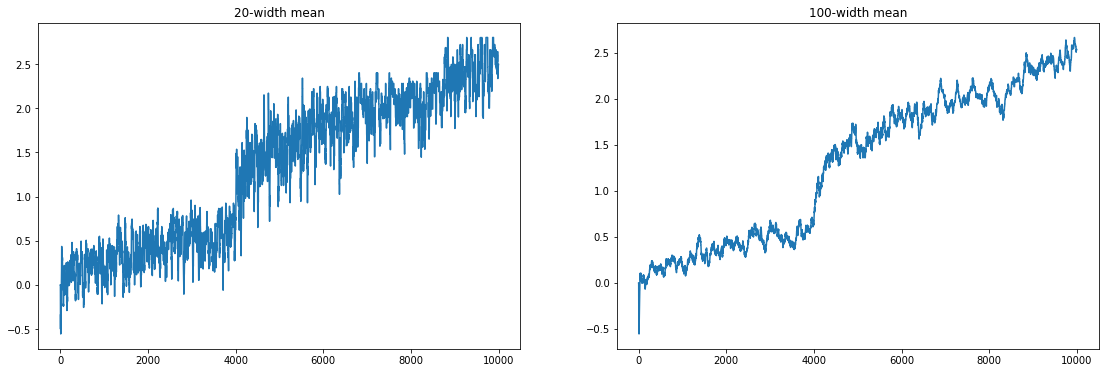

In [62]:
# Gamma = 0, epsilon exponentially 0.85 -> 0.05
monkey = Monkey()
monkey.gamma = 0
monkey.set_learn(10000)
monkey.plot_log(9999)


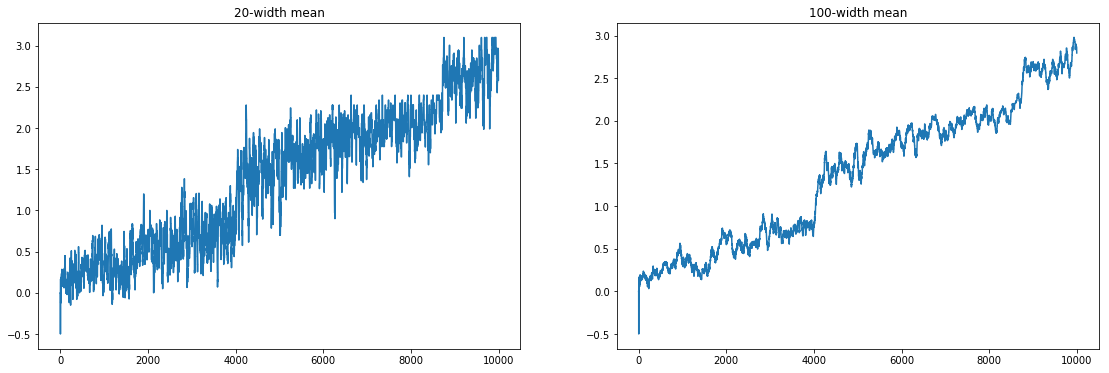

In [64]:
# Gamma = 0.3, epsilon exponentially 0.85 -> 0.05
monkey = Monkey()
monkey.gamma = 0.3
monkey.set_learn(10000)
monkey.plot_log(9999)


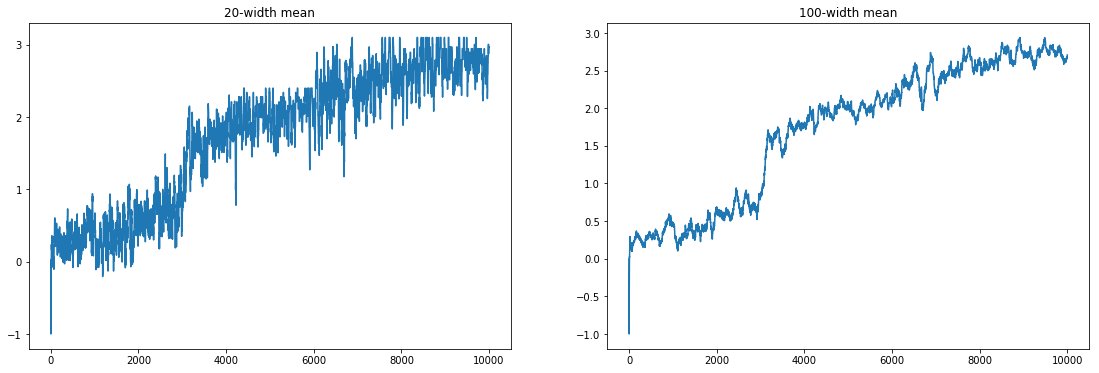

In [68]:
# Gamma = 0.6, epsilon exponentially 0.85 -> 0.05
monkey = Monkey()
monkey.gamma = 0.6
monkey.set_learn(10000)
monkey.plot_log(9999)


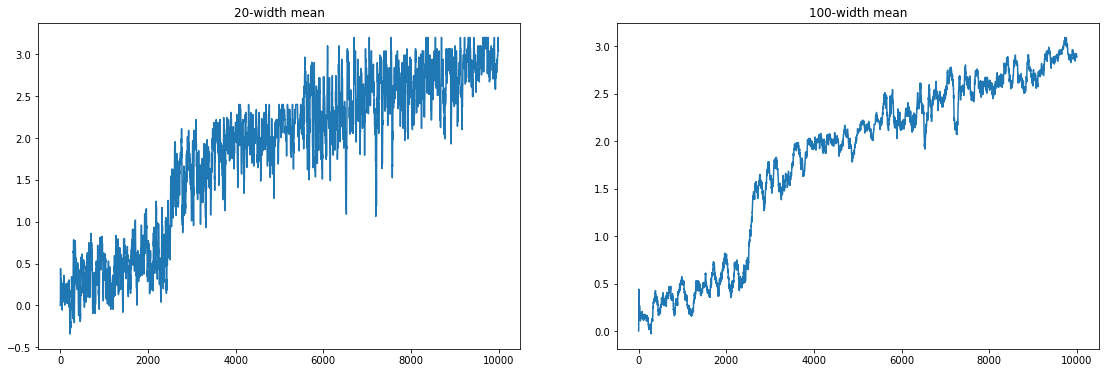

In [70]:
# Gamma = 0.9, epsilon exponentially 0.85 -> 0.05
monkey = Monkey()
monkey.gamma = 0.9
monkey.set_learn(10000)
monkey.plot_log(9999)


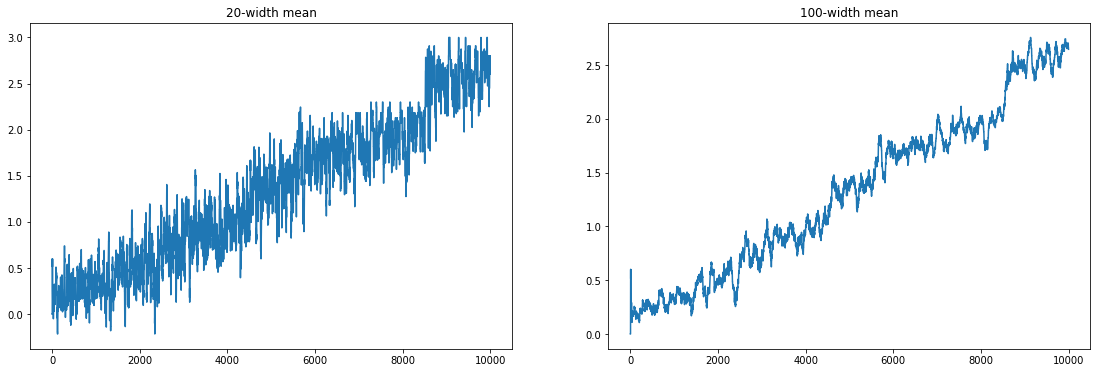

In [73]:
# Gamma = 0.4, epsilon 0
monkey = Monkey()
monkey.gamma = 0.4
monkey.epsilon = 0
monkey.set_learn(10000)
monkey.plot_log(9999)


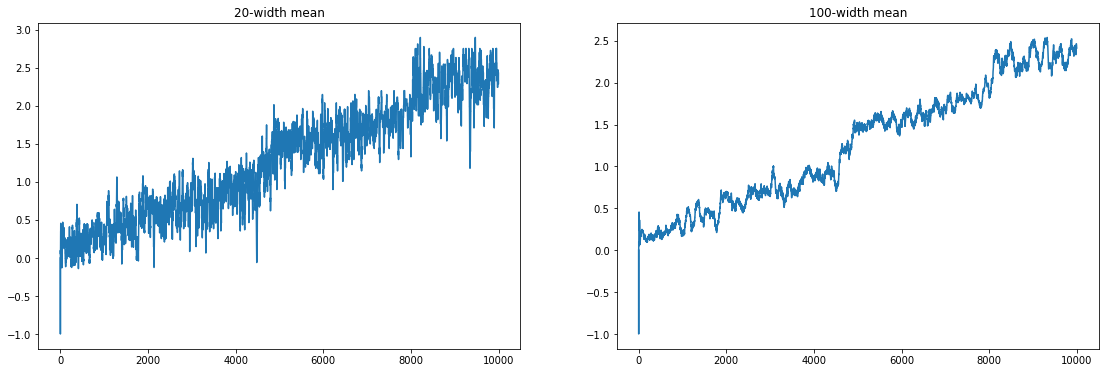

In [75]:
# Gamma = 0, epsilon = 0
monkey = Monkey()
monkey.gamma = 0
monkey.epsilon = 0
monkey.set_learn(10000)
monkey.plot_log(9999)


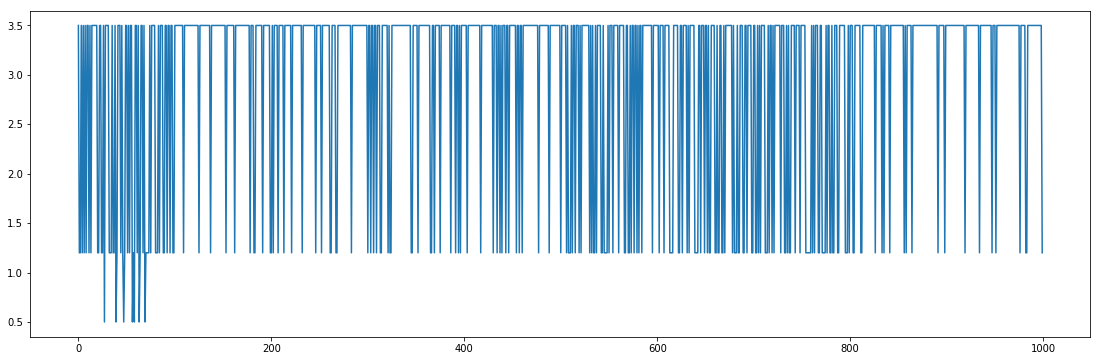

In [147]:

# Player test after training
played = np.zeros([1000])
monkey = Monkey()
monkey.learn(10000)
monkey.gamma = 0.4
plt.subplot(1, 1, 1)
plt.plot(played)
# monkey.play()
